In [1]:
from manim import *
import jupyter_capture_output

video_scene = " -v WARNING --progress_bar None --disable_caching coriolis_Scene"
image_scene = f" -v WARNING --progress_bar None --disable_caching -r {2*427},{2*240}  -s coriolis_Scene"

Manim Community v0.17.3

Jupyter Capture Output v0.0.11


In [3]:
def rk4_step(t, delta_t, y_array, ode, params):
    k1 = np.zeros_like(y_array)
    k2 = np.zeros_like(y_array)
    k3 = np.zeros_like(y_array)
    k4 = np.zeros_like(y_array)
    support = np.zeros_like(y_array)
    ode(t, y_array, k1, params) 

    # Berechnung k1 = f(t, y) * dt und support = y + k1/2
    k1 *= delta_t
    support = y_array + k1 / 2

    # Berechnung k2 = f(t+dt/2, y+k1/2) * dt und support = y + k2/2
    ode(t+delta_t/2, support, k2, params)
    k2 *= delta_t
    support = y_array + k2 / 2

    # Berechnung k3 = f(t+dt/2, y+k2/2) * dt und support = y + k3
    ode(t+delta_t/2, support, k3, params)
    k3 *= delta_t
    support = y_array + k3

    # Berechnung k4 = f(t+dt, y+k2) * dt und y_(i+1)
    ode(t+delta_t, support, k4, params)
    k4 *= delta_t
    y_array += (k1 + 2*k2 + 2*k3 + k4) / 6; 
    return

In [33]:
class PressureField(Mobject):
    def __init__(self, center = np.array([0, 0, 0]), low_center = np.array([-5, 0, 0]), high_center = np.array([5, 0, 0]), low = -5, high = 5, **kwargs):
        super().__init__(**kwargs)
        self.npla = NumberPlane(x_axis_config = {"stroke_opacity": 0.215, "stroke_color": BLACK}, y_axis_config = {"stroke_opacity": 0.125, "stroke_color": BLACK}, background_line_style = {"stroke_opacity": 0.125})
        self.add(self.npla)

        # parameters
        self.low_center = self.npla.c2p(*low_center)
        self.high_center = self.npla.c2p(*high_center)
        self.low = low
        self.high = high


        low_L = Text('L', color = BLUE).move_to(self.low_center)
        high_H = Text('H', color = RED).move_to(self.high_center)
        self.add(high_H, low_L)


    # scalar funcion returning air prssure
    def pressure(self, offset = 0):
        def parametric_pressure_function(x, y):
            pos = self.npla.c2p(x, y, 0)
            smoothing_factor = 10e-8
            pressure_low = self.low / (np.sqrt((pos[0]-self.low_center[0])**2 + (pos[1]-self.low_center[1])**2) + smoothing_factor)
            pressure_high = self.high / (np.sqrt((pos[0]-self.high_center[0])**2 + (pos[1]-self.high_center[1])**2) + smoothing_factor)
            return pressure_low + pressure_high + offset
        return parametric_pressure_function
    

    # returns x isobars
    def get_isobars(self, isobaric_density = 10):
        isobar_group = VGroup()
        for i in range(isobaric_density+1):
            offset = self.low + i * (self.high - self.low) / isobaric_density
            isobar_low = ImplicitFunction(self.pressure(offset), color = BLUE, stroke_width = 2, stroke_opacity = i/isobaric_density)
            isobar_high = ImplicitFunction(self.pressure(offset), color = RED, stroke_width = 2, stroke_opacity = 1 - i/isobaric_density)
            isobar_group.add(isobar_low, isobar_high)
        return isobar_group
    

    # force from air pressure gradient
    def get_grad_force(self, air_state, params):
        pressure_function = self.pressure()
        dr = 0.0001
        x = air_state[0]
        y = air_state[1]
        f_grad_x = -(pressure_function(x+dr, y) - pressure_function(x-dr, y)) / (2*dr)
        f_grad_y = -(pressure_function(x, y+dr) - pressure_function(x, y-dr)) / (2*dr)
        return (f_grad_x, f_grad_y)


    # coriolis force
    def get_coriolis_force(self, air_state, params):
        omega = params[1]
        v_x = air_state[2]
        v_y = air_state[3]
        f_coriolis_x = -omega * v_y
        f_coriolis_y = omega * v_x
        return (f_coriolis_x, f_coriolis_y)
    

    # force from fiction
    def get_friction_force(self, air_state, params):
        gamma = params[0]
        v_x = air_state[2]
        v_y = air_state[3]
        f_friction_x = -gamma * v_x
        f_friction_y = -gamma * v_y
        return (f_friction_x, f_friction_y)


    # ordinary differential equation for an air block in air_state with paramters (gamma, omega) for friction and earth rotation
    def ODE_Coriolis(self, t, air_state, f_air_state, params):
        # force from air pressure
        f_grad = self.get_grad_force(air_state, params)

        # coriolis force
        f_coriolis = self.get_coriolis_force(air_state, params)

        # force from friction
        f_friction = self.get_friction_force(air_state, params)

        # create derivation array for the air block
        f_air_state[0] = air_state[2]
        f_air_state[1] = air_state[3]
        f_air_state[2] = f_grad[0] + f_coriolis[0] + f_friction[0]
        f_air_state[3] = f_grad[1] + f_coriolis[1] + f_friction[1]
        return
    

    # builds block of air including arrows for forces
    def get_air_block(self, air_state, params, grad_arrow = True, coriolis_arrow = True, friction_arrow = False):
        air_block_group = VGroup()

        # arrow_parameters
        tip_width = 0.2
        tip_length = 0.2
        arrow_width = 3

        # air block
        air_pos = self.npla.c2p(air_state[0], air_state[1], 0)
        air_block = Square(side_length = 0.5, color = BLACK).move_to([air_pos])
        air_block_group.add(air_block)

        # arrow for gradient
        f_grad = self.get_grad_force(air_state, params)
        f_grad_pos = self.npla.c2p(f_grad[0], f_grad[1], 0)
        f_grad_arrow = Line(start = air_pos, end = air_pos+f_grad_pos, stroke_width = arrow_width, color = BLUE).add_tip(tip_width = tip_width, tip_length = tip_length)
        if grad_arrow:
            air_block_group.add(f_grad_arrow)

        # arrow for coriolis force
        f_coriolis = self.get_coriolis_force(air_state, params)
        f_coriolis_pos = self.npla.c2p(f_coriolis[0], f_coriolis[1], 0)
        f_coriolis_arrow = Line(start = air_pos, end = air_pos+f_coriolis_pos, stroke_width = arrow_width, color = GREY).add_tip(tip_width = tip_width, tip_length = tip_length)
        if coriolis_arrow:
            air_block_group.add(f_coriolis_arrow)

        # arrow for friction
        f_friction = self.get_friction_force(air_state, params)
        f_friction_pos = self.npla.c2p(f_friction[0], f_friction[1], 0)
        f_friction_arrow = Line(start = air_pos, end = air_pos+f_friction_pos, stroke_width = arrow_width, color = RED).add_tip(tip_width = tip_width, tip_length = tip_length)
        if friction_arrow:
            air_block_group.add(f_friction_arrow)

        # arrow for final force
        f_total = f_grad + f_coriolis + f_friction
        f_total_pos = self.npla.c2p(f_total[0], f_total[1], 0)
        f_total_arrow = Line(start = air_pos, end = air_pos+f_total_pos, stroke_width = arrow_width, color = BLACK).add_tip(tip_width = tip_width, tip_length = tip_length)
        air_block_group.add(f_total_arrow)
        
        return air_block_group


Output saved by creating file at animations/coriolis/coriolis_air.mp4.


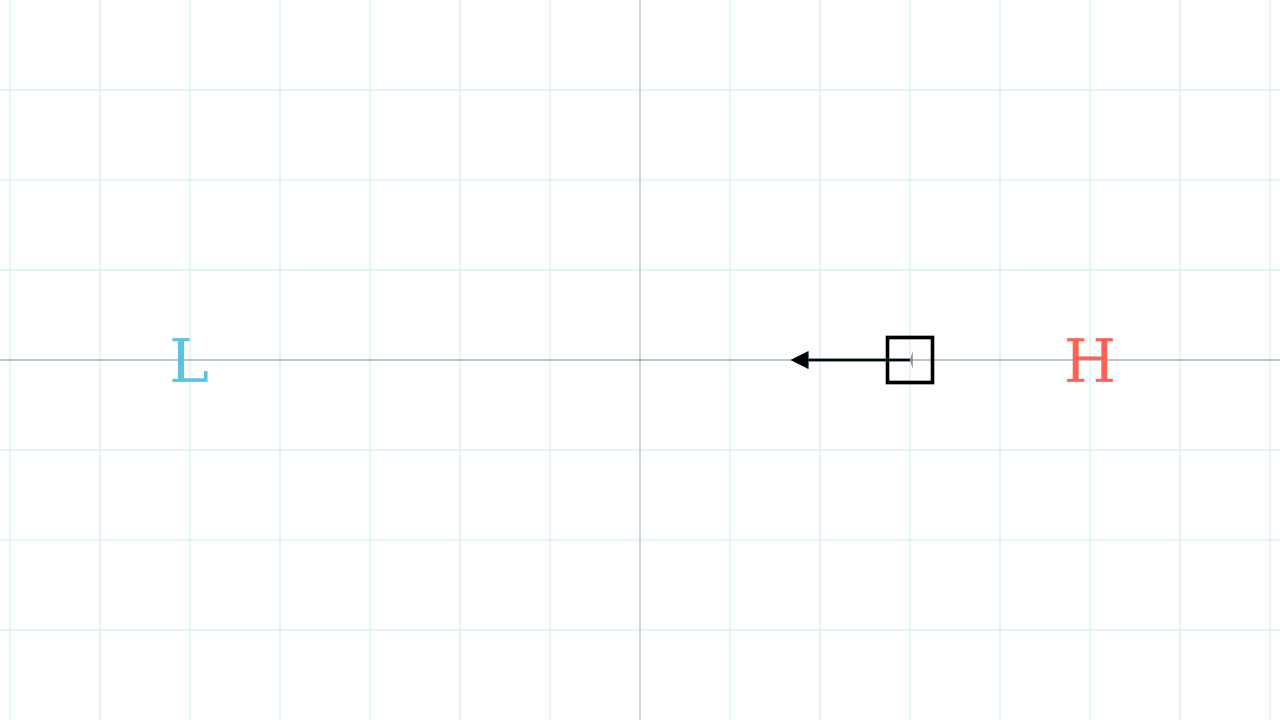

In [38]:
%%capture_video --path "animations/coriolis/coriolis_air.mp4"
%%manim -qm --fps 60 $video_scene

class coriolis_Scene(ThreeDScene):
    def construct(self):
        self.camera.background_color = WHITE

        # physical parameters
        gamma = 0           # friction coefficient
        omega = 1           # angular velocity of the earth
        params = (gamma, omega)

        # integration parameters
        t = 0               # initital time
        T_max = 10          # final time
        dt = 0.1            # stepsize

        # initial state of the air block
        x = 3
        y = 0
        v_x = 0
        v_y = 0
        air_state = np.array([x, y, v_x, v_y])


        pressure_field = PressureField(low_center = np.array([-5, 0, 0]))
        self.add(pressure_field)

        #isobars = pressure_field.get_isobars(isobaric_density = 17)
        #self.add(isobars)

        air_block = pressure_field.get_air_block(air_state, params)
        self.add(air_block)

        # numeric integration